<a href="https://colab.research.google.com/github/armiro/Dental-Caries-Classification/blob/master/periapical_dental_caries_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
%tensorflow_version 1.x
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, Add
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import glob, time, os, shutil

next_init_epoch = 0

Using TensorFlow backend.


In [6]:
# image data preparation
path = './drive/My Drive/periapical_dataset/healthy/**.jpg'
neg_images = list()
for img_name in glob.glob(pathname=path):
  img = load_img(path=img_name, color_mode='grayscale')
  img = img_to_array(img=img, data_format='channels_last')
  # img = np.expand_dims(a=img, axis=-1)
  neg_images.append(img)

neg_images = np.array(neg_images)
print('num healthy images:', len(neg_images))

path = './drive/My Drive/periapical_dataset/caries/**.jpg'
pos_images = list()
for img_name in glob.glob(pathname=path):
  img = load_img(path=img_name, color_mode='grayscale')
  img = img_to_array(img=img, data_format='channels_last')
  # img = np.expand_dims(a=img, axis=-1)
  pos_images.append(img)

pos_images = np.array(pos_images)
print('num carious images:', len(pos_images))

neg_labels = [0 for _ in range(len(neg_images))]
pos_labels = [1 for _ in range(len(pos_images))]

X = np.concatenate((pos_images, neg_images))
y = np.array(pos_labels + neg_labels)

print('num total dataset images:', len(X))
print('num total dataset labels:', len(y))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

num healthy images: 139
num carious images: 145
num total dataset images: 284
num total dataset labels: 284


In [0]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(rescale=1./255, rotation_range=0, zoom_range=[1., 2.], 
                         width_shift_range=0.25, height_shift_range=0.25, 
                         shear_range=0.15, horizontal_flip=True, 
                         vertical_flip=True, zca_whitening=True, fill_mode='nearest')

test_aug = ImageDataGenerator(rescale=1./255)

In [0]:
from keras import Model
inputA = Input(shape=X_train[0].shape)

x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(inputA)
x = BatchNormalization()(x)
x1 = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
x2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x1)
x2 = BatchNormalization()(x2)
x3 = MaxPooling2D(pool_size=2, strides=2, padding='same')(x2)
x4 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x3)
x4 = BatchNormalization()(x4)
x5 = MaxPooling2D(pool_size=2, strides=2, padding='same')(x4)
x6 = Flatten()(x5)
x7 = Dense(units=50, activation='relu')(x6)
x8 = Dense(units=25, activation='relu')(x7)
x9 = Dense(units=10, activation='relu')(x8)
x10 = Dense(units=1, activation='sigmoid')(x9)
net = Model(inputs=inputA, outputs=x10)

In [0]:
net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
net.summary()

In [0]:
def get_last_weights(folder):
  """
  find last saved weights file and its epoch number
  :param folder: string
  :return: int, string
  """
  num_epochs = list()
  for weights_file in glob.glob(folder + '/**.hdf5'):
    num_epoch = int(weights_file[weights_file.find('=')+1:weights_file.find('_')])
    num_epochs.append((num_epoch, weights_file))

  last_epoch = max(num_epochs)[0]
  print('last saved epoch:', last_epoch)
  last_file = max(num_epochs)[1]
  print('last saved file:', last_file)
  return last_epoch, last_file


def delete_other_weights(folder, last_file):
  """
  delete all weigths files saved before, except the last one which is the best
  :param folder: string
  :return None
  """

  for weights_file in os.listdir(folder):
      file_path = os.path.join(folder, weights_file)
      if file_path != last_file:
        try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)
        except Exception as e:
          print('failed to delete %s. because of: %s' % (file_path, e))
      else:
        pass
  print('deleted all weights files saved before, except the last one.')

In [0]:
# load the last saved weigths file as the model's weights and delete others
# run it ONLY if Google Colab stopped in the middle of model training
weights_folder = '/content/drive/My Drive/model'
next_init_epoch, last_epoch_weights_file = get_last_weights(weights_folder)
net.load_weights(last_epoch_weights_file)
delete_other_weights(folder=weights_folder, last_file=last_epoch_weights_file)

In [0]:
from keras.callbacks import ModelCheckpoint

file_path = '/content/drive/My Drive/model/epochs={epoch:03d}_valAcc={val_acc:.4f}.hdf5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

cb_list = [checkpoint]

In [0]:
net.fit_generator(generator=aug.flow(x=X_train, y=y_train, batch_size=16), 
                  steps_per_epoch=50, initial_epoch=next_init_epoch, epochs=400, 
                  verbose=1, callbacks=cb_list, validation_data=aug.flow(x=X_train, y=y_train, batch_size=16))


In [11]:
# save the final best weights and delete others (after training is finished)
weights_folder = '/content/drive/My Drive/model'
_, best_weights = get_last_weights(weights_folder)
acc = float(best_weights[best_weights.rfind('=')+1:best_weights.rfind('.')])
print('best validation accuracy:', acc)
net.load_weights(best_weights)
delete_other_weights(folder=weights_folder, last_file=best_weights)

last saved epoch: 301
last saved file: /content/drive/My Drive/model/epochs=301_valAcc=0.8678.hdf5
best validation accuracy: 0.8678
deleted all weights files saved before, except the last one.


In [12]:
from sklearn.metrics import confusion_matrix

y_pred = net.predict_generator(generator=test_aug.flow(x=X_test, batch_size=1, shuffle=False),
                               steps=len(X_test))
y_test = np.reshape(a=y_test, newshape=(1, -1))

print('num test-set images:', len(y_test[0]))
print(y_test)

y_pred = np.round(np.reshape(a=y_pred, newshape=(1, -1)), decimals=2)
print(y_pred)

y_pred_rnd = np.round(np.reshape(a=y_pred, newshape=(1, -1)))
cm = confusion_matrix(y_true=y_test[0], y_pred=y_pred_rnd[0])
print(cm)
print('test-set acc:', (cm[0][0] + cm[1][1])/np.sum(cm))

num test-set images: 57
[[0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1
  1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 1]]
[[0.   0.36 0.4  0.59 0.54 0.94 0.03 0.28 0.01 0.04 0.05 0.4  0.51 0.22
  1.   0.18 0.08 0.1  0.81 0.07 1.   1.   0.12 0.48 0.03 0.78 0.84 0.94
  0.85 0.83 0.99 0.25 0.1  0.5  1.   0.98 0.83 0.98 0.02 0.85 0.66 1.
  0.03 0.   0.92 0.06 0.99 0.68 0.6  0.02 0.14 0.9  0.46 0.64 0.03 0.53
  0.57]]
[[20  3]
 [ 8 26]]
test-set acc: 0.8070175438596491


In [0]:
# !pip install vis
!pip show vis
# !pip show pillow
# !pip install scipy==1.1.0
!pip show scipy

probability: [[0.8974062]]
probability: [[0.00017641]]
probability: [[0.09388584]]
probability: [[0.8757183]]


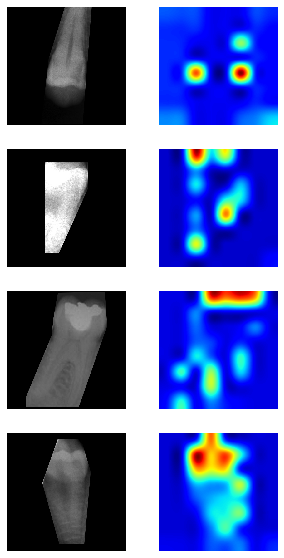

In [74]:
# draw the saliency map of the network (grad-CAM)
# from vis.visualization import visualize_saliency
# from vis.utils import utils
# from keras import activations

# test_img = X_train[41]
# test_img = np.array(test_img / 255.)

indices = np.random.randint(low=0, high=len(X_train), size=4)

from vis.visualization import visualize_cam
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (5,10)
f, ax = plt.subplots(len(indices), 2)
for i, idx in enumerate(indices):
  this_img = np.array(X_train[idx] / 255.)
  ax[i][0].imshow(this_img.squeeze(), cmap='gray', vmin=0, vmax=1)
  ax[i][0].axis('off')
  grads = visualize_cam(net, layer_idx=-1, filter_indices=None, seed_input=this_img, backprop_modifier=None)        
  ax[i][1].imshow(grads, cmap='jet')
  ax[i][1].axis('off')
  print('probability:', net.predict(np.expand_dims(this_img, axis=0)))
